# Pytinent Gen
## Creating Maps

## Perlin Noise
Perlin Noise is an important component of many procedural algorithms, valued for it's ability to create wave-like patterns that, while seemingly random, approximate natural patterns. Below is an implementation of Ken Perlin's 2002 update to perlin noise seen at http://mrl.nyu.edu/~perlin/noise/

In [1]:
#----- INIT IMPORTS AND SETUP -----
#----- Visualization -----
from IPython.core import page
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
page.page = print 
# --- Analysis Packages ---
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
#----- Files -----
import perlin

In [2]:
%pycat perlin.py

import numpy as np
import matplotlib.pyplot as plt
permutation = None

#----- PUBLIC PERLIN MAP FUNCTIONS -----
def perlin_map(x_size,y_size,scale,as_list=False):
    """Returns a perlin map of size x * y with the frequency as a scale"""
    linx = np.linspace(0,scale,x_size)
    liny =np.linspace(0,scale,y_size)
    x,y = np.meshgrid(linx,liny)
    map = __perlin(x,y)
    if as_list:
        return map.tolist()
    return map

#TODO Can this be optimized?
def octave_map(x_size,y_size,num_octaves,base_scale,as_list=False):
    """Returns a map of the sum of num_octaves perlin maps, each scaled down in amplitude by 1/n"""
    output = np.zeros((x_size,y_size))
    for n in range(1,num_octaves+1):
        output += perlin_map(x_size,y_size,base_scale*n)*(1/n)
    return output

#----- PERMUTATION FUNCTIONS -----
#This shouldn't really ever change, but the modularity is there
def __get_permutation(size=256):
    """Returns the permutation map or creates one if it doesn't exist or is the w

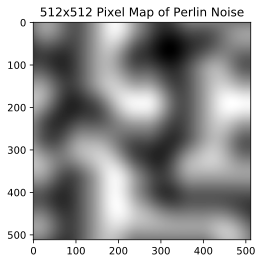

In [3]:
MAP_SIZE = 512

map = perlin.perlin_map(MAP_SIZE,MAP_SIZE,4)
plt.rcParams['image.cmap'] = 'gray'
plt.title("512x512 Pixel Map of Perlin Noise")
plt.imshow(map)
pylab.show()

**By scaling the inputs we can create various grades of noise:**

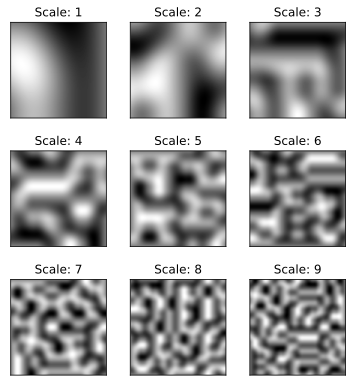

In [4]:
plt.figure(1)
for n in range(1,10):
    map = perlin.perlin_map(MAP_SIZE,MAP_SIZE,n)
    plt.subplot(3,3,n)
    plt.title("Scale: "+str(n))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(map) 
plt.subplots_adjust(hspace=0.25, wspace=0.25,top=2,bottom=0.75)

Instead of using greyscale, let's switch the color scheme over to pyplot's handy "terrain" color scheme:

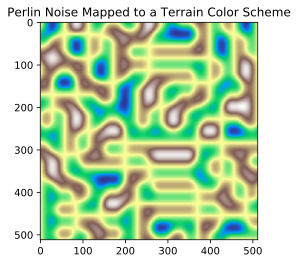

In [5]:
plt.rcParams['image.cmap'] = 'terrain'
plt.title("Perlin Noise Mapped to a Terrain Color Scheme")
plt.imshow(map)
None

## Octaves

This image is nice, but the contour can be improved by beginning with a low scale and layering on higher scale images on top. By assigning these different "octaves" successively lower weights, we can get a fractal-like pattern that looks much better than a single pass of perlin noise:

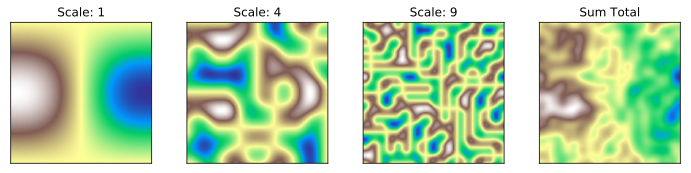

In [6]:
plt.figure(figsize=(12,15))
sum_map = np.zeros((MAP_SIZE,MAP_SIZE))
#This feature is in the perlin.py file as octave_map()
for n in range(1,4):
    map = perlin.perlin_map(MAP_SIZE,MAP_SIZE,(n)*n) * (1/n) #weight of each map is 1/n
    sum_map += map
    plt.subplot(1,4,n)
    plt.title("Scale: "+str((n)*n))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(map)     
plt.subplot(1,4,4)
plt.imshow(sum_map)
plt.title("Sum Total")
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.25, wspace=0.25,top=2,bottom=0.5)
None


Looking more closely at the final product many of the unseemly lines and bare geometry of the original noise passes have given way to a very natural looking terrain:

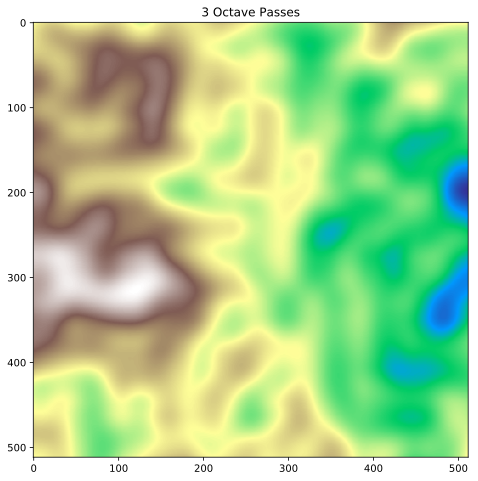

In [9]:
plt.figure(figsize = (30,8))
plt.imshow(sum_map)
plt.title("3 Octave Passes")
None

Experimenting with different scales and weights for the noise function will allow for even more control of the terrain's final look.